In [412]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os 
import sklearn
from data_preperation import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [413]:
data_original = pd.read_csv('ElectionsData.csv', header=0)
data_original.head()

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Last_school_grades,Most_Important_Issue,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Financial_agenda_matters,Num_of_kids_born_last_10_years,Overall_happiness_score
0,Violets,1.0,113.445801,1688.510190,Below_30,1477.809692,Yes,202.042787,Yes,Male,...,60.0,Financial,12.0,683.760440,1.0,Public_or_other,Industry_or_other,No,1.0,392.803101
1,Browns,2.0,161.720841,696.069582,Below_30,2969.865888,Yes,88.942300,Yes,Male,...,60.0,Financial,9.0,793.017823,2.0,Car,Industry_or_other,No,0.0,41.028616
2,Greens,6.0,524.947117,50048.853880,30-45,30803.812970,No,789.796962,Yes,Female,...,80.0,Healthcare,10.0,253.102383,1.0,Motorcycle_or_truck,Services_or_Retail,No,0.0,635.000942
3,Whites,1.0,521.454363,50265.185360,Below_30,30396.557250,No,565.727946,Yes,Male,...,NaN,Social,8.0,278.904297,1.0,Car,Services_or_Retail,No,0.0,502.278182
4,Browns,6.0,210.879361,7793.195795,30-45,5021.415879,No,423.589896,Yes,Female,...,70.0,Social,11.0,605.564038,4.0,Car,Public_Sector,No,2.0,40.469037


In [414]:
discrete_features = ['Occupation_Satisfaction', 'Last_school_grades', 'Number_of_differnt_parties_voted_for', 'Number_of_valued_Kneset_members', 'Num_of_kids_born_last_10_years']
continuous_features = ['Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
                      'Financial_balance_score_(0-1)', '%Of_Household_Income', 'Yearly_IncomeK', 'Avg_size_per_room', 'Garden_sqr_meter_per_person_in_residancy_area', 'Avg_Residancy_Altitude',
                      'Yearly_ExpensesK', '%Time_invested_in_work', 'Avg_education_importance', 'Avg_Satisfaction_with_previous_vote', 
                      'Avg_monthly_household_cost', 'Phone_minutes_10_years', 'Avg_government_satisfaction', 'Weighted_education_rank', '%_satisfaction_financial_policy',
                      'Avg_monthly_income_all_years', 'Political_interest_Total_Score', 'Overall_happiness_score']
nominal_features = ['Vote', 'Will_vote_only_large_party', 'Age_group', 'Voting_Time']
onehot_nominal_features = ['Most_Important_Issue', 'Main_transportation', 'Occupation']
binary_features = ['Gender', 'Looking_at_poles_results', 'Married', 'Financial_agenda_matters']

numerical_features = discrete_features + continuous_features
total_nominal_features = nominal_features + onehot_nominal_features + binary_features

In [415]:
uniform_features = ['Occupation_Satisfaction', 'Financial_balance_score_(0-1)',
                    '%Of_Household_Income', 'Yearly_IncomeK', 'Avg_government_satisfaction',
                    '%_satisfaction_financial_policy', 'Garden_sqr_meter_per_person_in_residancy_area',
                    'Yearly_ExpensesK', '%Time_invested_in_work']
normal_features = ['Number_of_differnt_parties_voted_for', 'Number_of_valued_Kneset_members',
                   'Avg_environmental_importance',
                   'Avg_education_importance', 'Avg_monthly_household_cost', 'Weighted_education_rank',
                   'Overall_happiness_score', 'Avg_size_per_room', 'Avg_Residancy_Altitude']
unknown_features = ['Last_school_grades', 'Num_of_kids_born_last_10_years',
                    'Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses',
                    'Avg_monthly_expense_on_pets_or_plants', 'Avg_Satisfaction_with_previous_vote',
                    'Phone_minutes_10_years', 'Avg_monthly_income_all_years', 'Political_interest_Total_Score']

features_with_negative = {'Avg_monthly_expense_when_under_age_21': 147, 'Avg_lottary_expanses': 152 ,
                          'Avg_monthly_income_all_years': 152}

Questions:
1. unknown featuers - to which distribution they belong
- which scaling/noramalization should we use on them
2. How to check dependencies between feature before and after scaling
3. When should we use one hot transformation
4. Should we remove negative or change to positive
5. Should we use closeset fit to imputate
6. What algos we need to use to feature select (*which ones exict in sklearn)


In [416]:
data = data_original.copy()


In [417]:
data = convert_to_onehot(data, onehot_nominal_features)
data

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Most_Important_Issue_Social,Main_transportation_Car,Main_transportation_Foot_or_bicycle,Main_transportation_Motorcycle_or_truck,Main_transportation_Public_or_other,Occupation_Hightech,Occupation_Industry_or_other,Occupation_Public_Sector,Occupation_Services_or_Retail,Occupation_Student_or_Unemployed
0,Violets,1.0,113.445801,1688.510190,Below_30,1477.809692,Yes,202.042787,Yes,Male,...,0,0,0,0,1,0,1,0,0,0
1,Browns,2.0,161.720841,696.069582,Below_30,2969.865888,Yes,88.942300,Yes,Male,...,0,1,0,0,0,0,1,0,0,0
2,Greens,6.0,524.947117,50048.853880,30-45,30803.812970,No,789.796962,Yes,Female,...,0,0,0,1,0,0,0,0,1,0
3,Whites,1.0,521.454363,50265.185360,Below_30,30396.557250,No,565.727946,Yes,Male,...,1,1,0,0,0,0,0,0,1,0
4,Browns,6.0,210.879361,7793.195795,30-45,5021.415879,No,423.589896,Yes,Female,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Purples,9.0,124.023053,26638.227290,30-45,1760.420762,No,1060.517225,No,Female,...,0,0,0,1,0,0,0,1,0,0
9996,Blues,1.0,1146.385393,245768.367300,30-45,146414.291700,No,826.909059,No,Female,...,0,0,0,0,1,1,0,0,0,0
9997,Turquoises,7.0,173.952313,20598.709440,45_and_up,3430.140470,No,690.466486,Yes,Female,...,0,0,1,0,0,0,1,0,0,0
9998,Oranges,10.0,307.277614,41875.937280,45_and_up,10603.484990,No,547.345514,Yes,Female,...,0,0,0,1,0,0,1,0,0,0


In [418]:
data = convert_to_categorical(data)
data

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Most_Important_Issue_Social,Main_transportation_Car,Main_transportation_Foot_or_bicycle,Main_transportation_Motorcycle_or_truck,Main_transportation_Public_or_other,Occupation_Hightech,Occupation_Industry_or_other,Occupation_Public_Sector,Occupation_Services_or_Retail,Occupation_Student_or_Unemployed
0,10,1.0,113.445801,1688.510190,2,1477.809692,1,202.042787,1,1,...,0,0,0,0,1,0,1,0,0,0
1,1,2.0,161.720841,696.069582,2,2969.865888,1,88.942300,1,1,...,0,1,0,0,0,0,1,0,0,0
2,2,6.0,524.947117,50048.853880,0,30803.812970,0,789.796962,1,0,...,0,0,0,1,0,0,0,0,1,0
3,11,1.0,521.454363,50265.185360,2,30396.557250,0,565.727946,1,1,...,1,1,0,0,0,0,0,0,1,0
4,1,6.0,210.879361,7793.195795,0,5021.415879,0,423.589896,1,0,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,9.0,124.023053,26638.227290,0,1760.420762,0,1060.517225,0,0,...,0,0,0,1,0,0,0,1,0,0
9996,0,1.0,1146.385393,245768.367300,0,146414.291700,0,826.909059,0,0,...,0,0,0,0,1,1,0,0,0,0
9997,9,7.0,173.952313,20598.709440,1,3430.140470,0,690.466486,1,0,...,0,0,1,0,0,0,1,0,0,0
9998,5,10.0,307.277614,41875.937280,1,10603.484990,0,547.345514,1,0,...,0,0,0,1,0,0,1,0,0,0


C:\Users\aviv_\Miniconda3\envs\cs236756\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


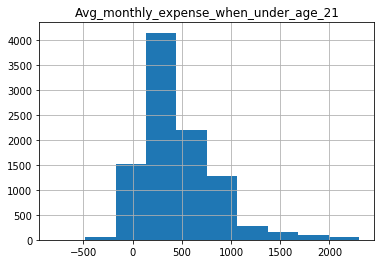

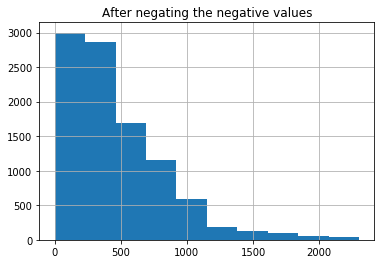

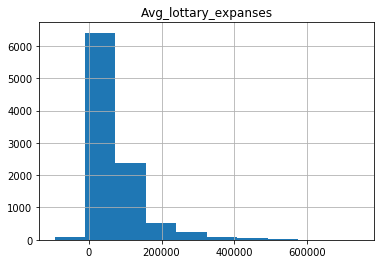

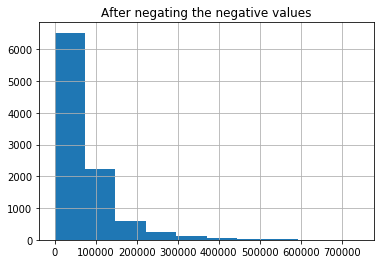

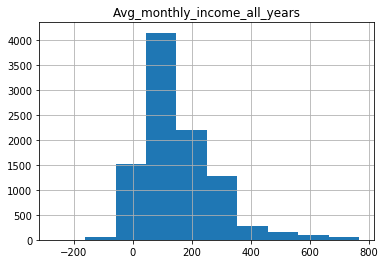

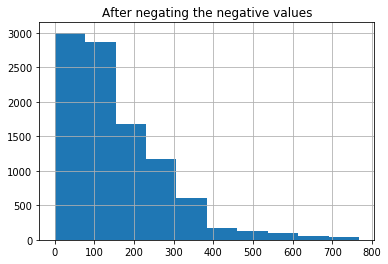

In [397]:
# Looks like the negative data is simillar to the distributaion of the data so maybe we need to negate it 
# instead of removing it
for feature in features_with_negative.keys():
    plt.figure();
    data[feature].hist()
    plt.title(feature)
    plt.figure();
    data.loc[:,feature][data[feature] < 0] = data.loc[:,feature][data[feature] < 0].abs()
    data[feature].hist()
    plt.title('After negating the negative values')
#data.loc[:, features_with_negative.keys()][data.loc[:, features_with_negative.keys()] < 0].hist(figsize=(16,16))
# Notice - this does not change the corr between the features

In [398]:
# Split
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, test_size=0.15, val_size=0.15)

In [399]:
XY_train = insert_label_to_data(X_train, y_train)


print(f'Number of negative values: {(XY_train.dropna().values < 0).sum()}')
XY_train = remove_negative(XY_train) # TODO check if removing is good or maybe abs
print(f'Number of negative values: {(XY_train.dropna().values < 0).sum()}')

print(f'Number of nan before: {XY_train.isnull().values.sum()}')
outlier = Outlier(XY_train)
XY_train = outlier.remove_outlier(XY_train, 3)
print(f'Number of nan after: {XY_train.isnull().values.sum()}')


Number of negative values: 0
Number of negative values: 0
Number of nan before: 3969
Number of nan after: 4334


In [400]:

print(f'Number of nan before: {XY_train.isnull().values.sum()}')
imputation = Imputation(XY_train)
XY_train = imputation.impute_train(XY_train)
print(f'Number of nan after: {XY_train.isnull().values.sum()}')        


Number of nan before: 4334
Number of nan after: 0


In [401]:
print(f'Number of nan before: {X_test.isnull().values.sum() + X_val.isnull().values.sum()}')
X_test, X_val = imputation.impute_test_val(X_test, X_val)
print(f'Number of nan after: {X_test.isnull().values.sum() + X_val.isnull().values.sum()}')  

Number of nan before: 1746
Number of nan after: 0


In [402]:
scaler = Scaling(XY_train)
XY_train = scaler.scale_min_max(XY_train, uniform_features, -1, 1) 
XY_train = scaler.normalization(XY_train, normal_features + unknown_features) 
X_val = scaler.scale_min_max(X_val, uniform_features, -1, 1) 
X_val = scaler.normalization(X_val, normal_features + unknown_features) 
X_test = scaler.scale_min_max(X_test, uniform_features, -1, 1) 
X_test = scaler.normalization(X_test, normal_features + unknown_features) 

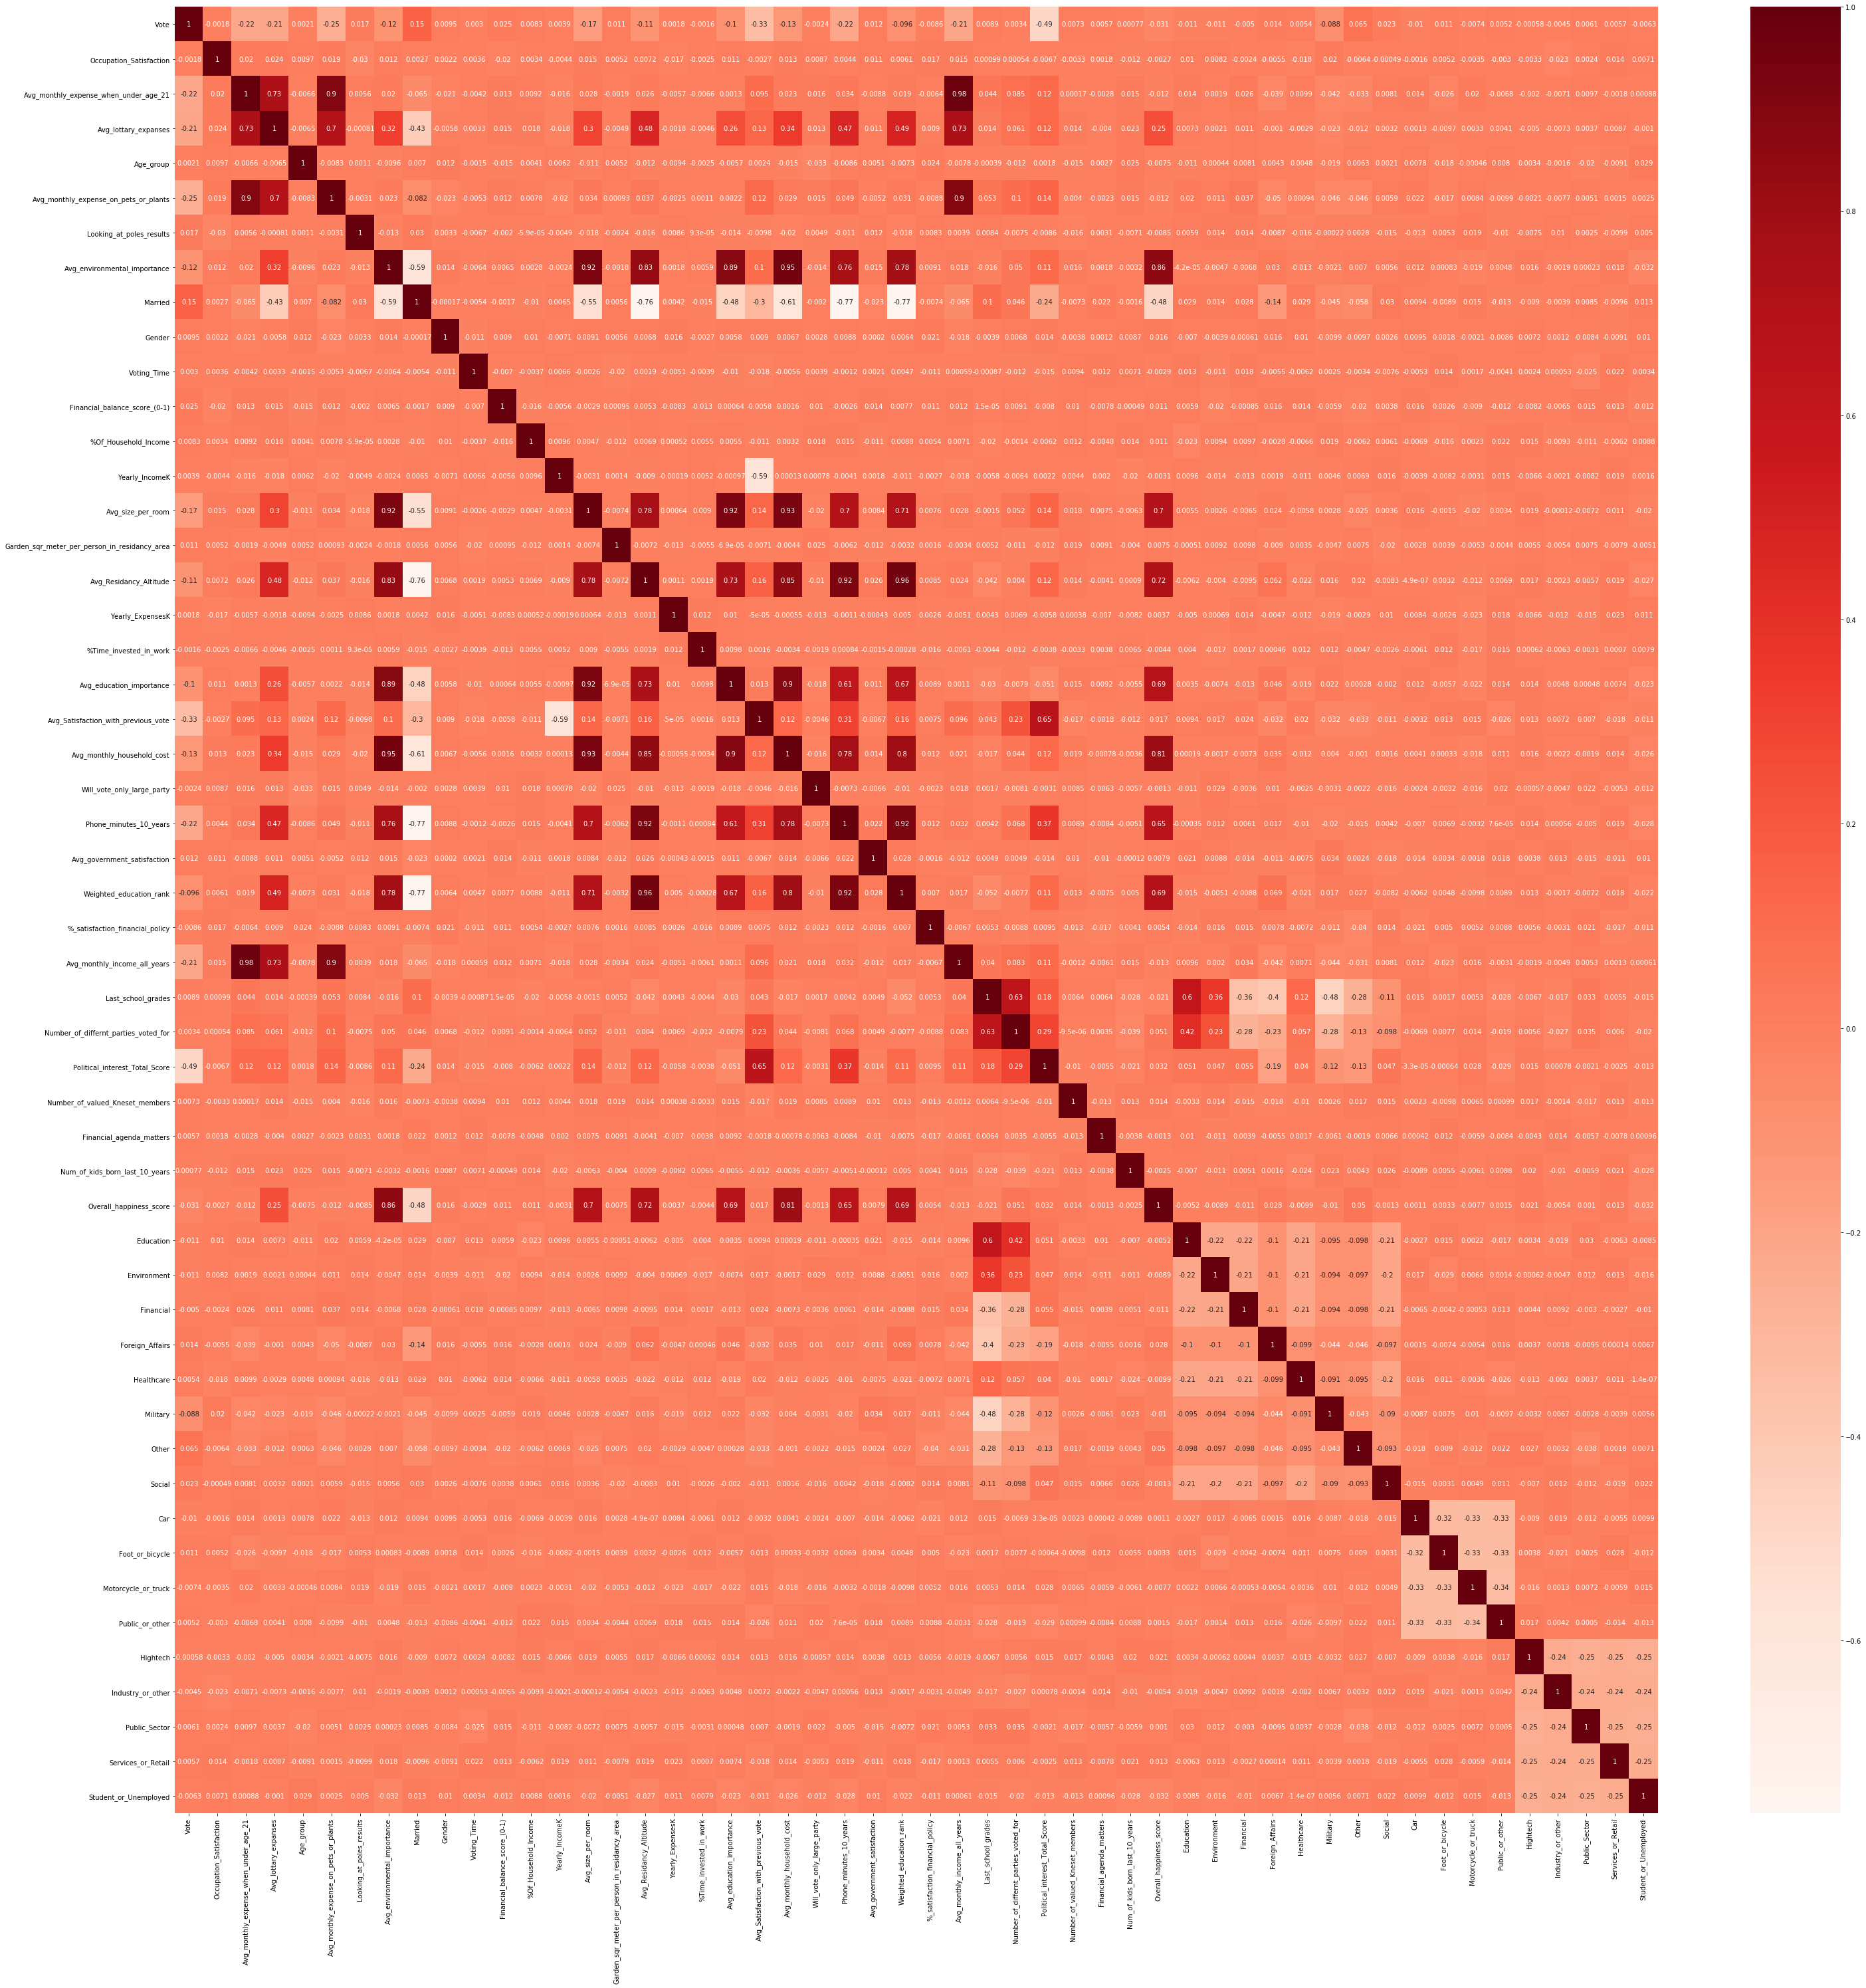

In [403]:
#to_remove  = ['Avg_monthly_expense_on_pets_or_plants', 'Avg_monthly_income_all_years', 'Avg_size_per_room', 'Avg_monthly_household_cost', 'Avg_education_importance',
#             'Phone_minutes_10_years', 'Weighted_education_rank']
#XY_train = XY_train.drop(columns=to_remove)
#print(XY_train.columns.values)

# using pearson correlation to find correlation between all features (this finds only linear relations)
import seaborn as sns
plt.figure(figsize=(50, 50))
cor = XY_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [ ]:
cor = cor[abs(cor)>0.2]
cor.to_csv('correlation_matrix.csv')

In [108]:
from test import test_accuracy
X_train, y_train = split_label_from_data(XY_train)
print(test_accuracy(X_train[['Married',
 'Avg_education_importance',
 'Weighted_education_rank',
 'Last_school_grades',
 'Number_of_differnt_parties_voted_for',
 'Overall_happiness_score',
 'Education',
 'Financial',
 'Foreign_Affairs',
 'Military',
 'Other',
 'Social']], y_train, X_val[['Married',
 'Avg_education_importance',
 'Weighted_education_rank',
 'Last_school_grades',
 'Number_of_differnt_parties_voted_for',
 'Overall_happiness_score',
 'Education',
 'Financial',
 'Foreign_Affairs',
 'Military',
 'Other',
 'Social']], y_val))

{'svm': 0.84, 'forest': 0.878, 'knn': 0.8446666666666667, 'perceptron': 0.6053333333333333, 'bn': 0.736}


no feature selection, with scaling{'svm': 0.23933333333333334, 'forest': 0.8966666666666666, 'knn': 0.5406666666666666, 'perceptron': 0.19466666666666665, 'bn': 0.6233333333333333}
with feature selection {'svm': 0.7993333333333333, 'forest': 0.88, 'knn': 0.8473333333333334, 'perceptron': 0.244, 'bn': 0.7433333333333333}
with fs no scaling {'svm': 0.33066666666666666, 'forest': 0.8866666666666667, 'knn': 0.7526666666666667, 'perceptron': 0.242, 'bn': 0.7446666666666667}
with fs and scaling unknown {'svm': 0.84, 'forest': 0.8806666666666667, 'knn': 0.8446666666666667, 'perceptron': 0.43333333333333335, 'bn': 0.736}

In [ ]:
#Test for SFS algorithem
from feature_selection import SFS
from sklearn.neighbors import KNeighborsClassifier

forest = KNeighborsClassifier()

selected_features = SFS(forest, X_train,y_train,X_val,y_val) 
selected_features

In [404]:
from feature_selection import *
best = 0
best_k = 0
for k in range(13, 24):
    X_train, y_train = split_label_from_data(XY_train)
    features = selectKBest_features_selection(X_train, y_train, k)
    accuracy = test_accuracy(X_train[features], y_train, X_val[features], y_val)
    print(f'k = {k} {accuracy}')

    if isinstance(best, int):
        best = accuracy
        best_k = k
    elif sum(list(accuracy.values())) > sum(list(best.values())):
        best = accuracy
        best_k = k
print(best)
print(best_k)

k = 13 {'svm': 0.888, 'forest': 0.909, 'knn': 0.85, 'sgd': 0.756, 'bn': 0.778}
k = 14 {'svm': 0.891, 'forest': 0.917, 'knn': 0.834, 'sgd': 0.74, 'bn': 0.781}
k = 15 {'svm': 0.89, 'forest': 0.912, 'knn': 0.832, 'sgd': 0.735, 'bn': 0.777}
k = 16 {'svm': 0.884, 'forest': 0.909, 'knn': 0.823, 'sgd': 0.751, 'bn': 0.769}
k = 17 {'svm': 0.875, 'forest': 0.91, 'knn': 0.824, 'sgd': 0.735, 'bn': 0.774}
k = 18 {'svm': 0.876, 'forest': 0.907, 'knn': 0.825, 'sgd': 0.758, 'bn': 0.757}
k = 19 {'svm': 0.874, 'forest': 0.91, 'knn': 0.825, 'sgd': 0.782, 'bn': 0.745}
k = 20 {'svm': 0.874, 'forest': 0.905, 'knn': 0.833, 'sgd': 0.786, 'bn': 0.795}
k = 21 {'svm': 0.873, 'forest': 0.907, 'knn': 0.833, 'sgd': 0.776, 'bn': 0.795}
k = 22 {'svm': 0.873, 'forest': 0.916, 'knn': 0.835, 'sgd': 0.795, 'bn': 0.795}
k = 23 {'svm': 0.876, 'forest': 0.916, 'knn': 0.833, 'sgd': 0.799, 'bn': 0.783}
{'svm': 0.873, 'forest': 0.916, 'knn': 0.835, 'sgd': 0.795, 'bn': 0.795}
22


In [ ]:
k = 5 {'svm': 0.744, 'forest': 0.813, 'knn': 0.778, 'sgd': 0.543, 'bn': 0.652}
k = 6 {'svm': 0.795, 'forest': 0.85, 'knn': 0.796, 'sgd': 0.61, 'bn': 0.704}
k = 7 {'svm': 0.857, 'forest': 0.874, 'knn': 0.821, 'sgd': 0.691, 'bn': 0.743}
k = 8 {'svm': 0.876, 'forest': 0.885, 'knn': 0.831, 'sgd': 0.737, 'bn': 0.794}
k = 9 {'svm': 0.876, 'forest': 0.902, 'knn': 0.828, 'sgd': 0.737, 'bn': 0.787}
k = 10 {'svm': 0.877, 'forest': 0.902, 'knn': 0.83, 'sgd': 0.757, 'bn': 0.781}
k = 11 {'svm': 0.879, 'forest': 0.895, 'knn': 0.829, 'sgd': 0.769, 'bn': 0.745}
k = 12 {'svm': 0.876, 'forest': 0.884, 'knn': 0.829, 'sgd': 0.777, 'bn': 0.719}
k = 13 {'svm': 0.875, 'forest': 0.896, 'knn': 0.835, 'sgd': 0.791, 'bn': 0.795}
k = 14 {'svm': 0.873, 'forest': 0.891, 'knn': 0.833, 'sgd': 0.786, 'bn': 0.796}
k = 15 {'svm': 0.865, 'forest': 0.878, 'knn': 0.816, 'sgd': 0.787, 'bn': 0.796}
{'svm': 0.875, 'forest': 0.896, 'knn': 0.835, 'sgd': 0.791, 'bn': 0.795}
13

In [405]:
features = selectKBest_features_selection(X_train, y_train, 14)
print(features)
print(test_accuracy(X_train[features], y_train, X_val[features], y_val))

#to_remove = ['Avg_monthly_expense_on_pets_or_plants','Avg_monthly_income_all_years','Avg_size_per_room', 'Avg_education_importance', 'Avg_monthly_household_cost',
#            'Phone_minutes_10_years', 'Weighted_education_rank']
#features = [x for x in features if x not in to_remove]
#plt.figure(figsize=(32, 32))
#cor = XY_train[features].corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()


['Avg_monthly_expense_on_pets_or_plants' 'Avg_environmental_importance'
 'Avg_size_per_room' 'Avg_Residancy_Altitude' 'Avg_education_importance'
 'Avg_Satisfaction_with_previous_vote' 'Avg_monthly_household_cost'
 'Phone_minutes_10_years' 'Weighted_education_rank'
 'Avg_monthly_income_all_years' 'Last_school_grades'
 'Number_of_differnt_parties_voted_for' 'Political_interest_Total_Score'
 'Overall_happiness_score']
{'svm': 0.891, 'forest': 0.917, 'knn': 0.834, 'sgd': 0.759, 'bn': 0.781}


Feature ranking:
1. feature 29 (0.085710)
2. feature 33 (0.074424)
3. feature 28 (0.065219)
4. feature 24 (0.062423)
5. feature 19 (0.051610)
6. feature 6 (0.049519)
7. feature 22 (0.049432)
8. feature 15 (0.044865)
9. feature 13 (0.042251)
10. feature 20 (0.040914)
11. feature 18 (0.038708)
12. feature 27 (0.030003)
13. feature 7 (0.029904)
14. feature 40 (0.026410)
15. feature 4 (0.023134)
16. feature 37 (0.023027)
17. feature 1 (0.022625)
18. feature 26 (0.021204)
19. feature 39 (0.019550)
20. feature 2 (0.018725)
21. feature 12 (0.010550)
22. feature 25 (0.007531)
23. feature 23 (0.007446)
24. feature 0 (0.007407)
25. feature 17 (0.007344)
26. feature 10 (0.007294)
27. feature 14 (0.007289)
28. feature 11 (0.007046)
29. feature 16 (0.006953)
30. feature 36 (0.006845)
31. feature 30 (0.006762)
32. feature 3 (0.006506)
33. feature 21 (0.006352)
34. feature 41 (0.005841)
35. feature 32 (0.005764)
36. feature 31 (0.005607)
37. feature 5 (0.005481)
38. feature 9 (0.005479)
39. feature 8

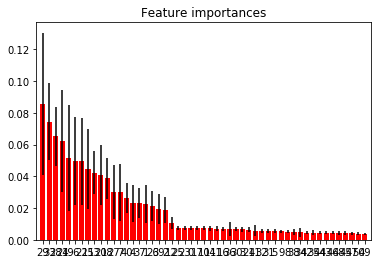

['Avg_environmental_importance' 'Married' 'Avg_size_per_room'
 'Avg_Residancy_Altitude' 'Avg_education_importance'
 'Avg_Satisfaction_with_previous_vote' 'Avg_monthly_household_cost'
 'Phone_minutes_10_years' 'Weighted_education_rank' 'Last_school_grades'
 'Number_of_differnt_parties_voted_for' 'Political_interest_Total_Score'
 'Overall_happiness_score' 'Other']
{'svm': 0.871, 'forest': 0.898, 'knn': 0.841, 'sgd': 0.707, 'bn': 0.71}


In [408]:
X_train, y_train = split_label_from_data(XY_train)
features = sklearn_ExtraTree_feature_selection(X_train, y_train, 19)
print(X_train.columns.values[sorted(features)])
print(test_accuracy(X_train.iloc[:,features], y_train, X_val.iloc[:,features], y_val))
features = list(X_train.columns.values[features]) 


In [409]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

selected_features = SFS(forest, X_train,y_train,X_val,y_val) 
selected_features

[22]
[22, 13]
[22, 13, 33]
[22, 13, 33, 27]
[22, 13, 33, 27, 1]
[22, 13, 33, 27, 1, 28]
[22, 13, 33, 27, 1, 28, 6]
[22, 13, 33, 27, 1, 28, 6, 29]
[22, 13, 33, 27, 1, 28, 6, 29, 37]
[22, 13, 33, 27, 1, 28, 6, 29, 37, 39]
[22, 13, 33, 27, 1, 28, 6, 29, 37, 39]


['Avg_monthly_expense_when_under_age_21',
 'Avg_environmental_importance',
 'Avg_size_per_room',
 'Phone_minutes_10_years',
 'Last_school_grades',
 'Number_of_differnt_parties_voted_for',
 'Political_interest_Total_Score',
 'Overall_happiness_score',
 'Foreign_Affairs',
 'Military']

In [411]:
print(test_accuracy(X_train.loc[:,selected_features], y_train, X_val.loc[:,selected_features], y_val))
#plt.figure(figsize=(32, 32))
#cor = XY_train[selected_features].corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()

{'svm': 0.881, 'forest': 0.919, 'knn': 0.839, 'sgd': 0.753, 'bn': 0.719}


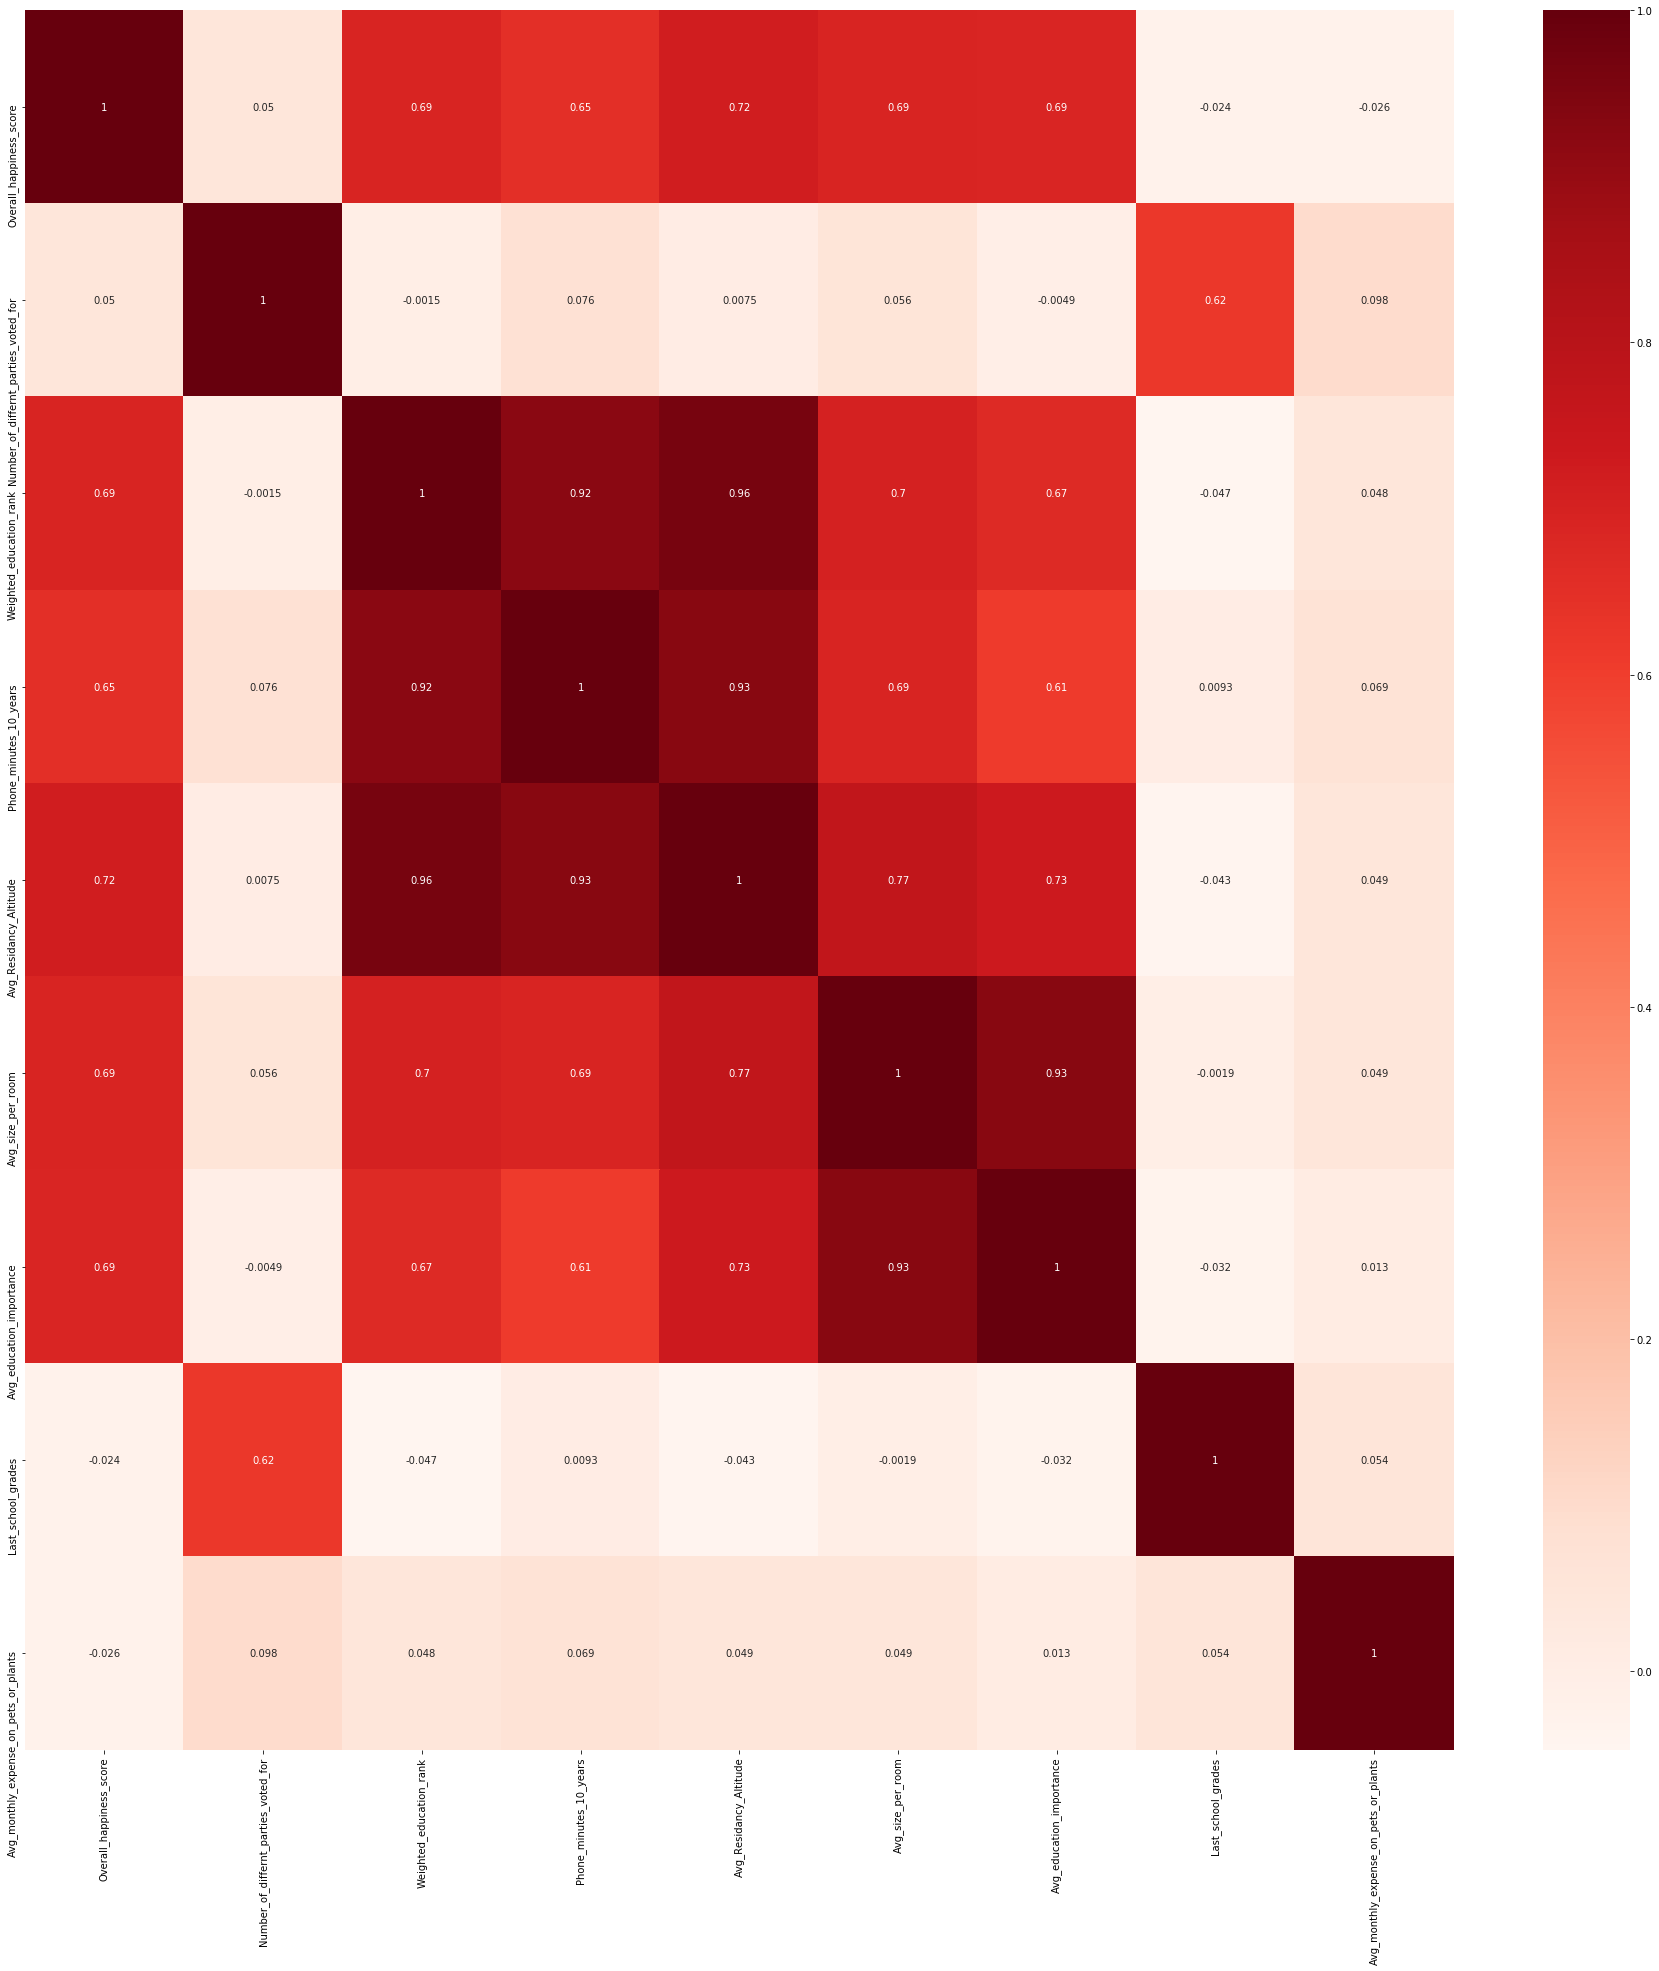

In [364]:
plt.figure(figsize=(32, 32))
cor = XY_train[selected_features].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()